# Starbucks Capstone Challenge

### Project Overview

This dataset contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this dataset.

Our task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. We'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

Someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Problem Statement 

The goal of this project is to build a machine learning model to predict whether a customer would complete an offer provided by the Starbucks rewards program. The primary expectation is to assess the influence of demographic factors such as age, gender and income on the likelihood of a customer successfully completing an offer.

### Approach

The project involves data preprocessing, exploratory data analysis, feature engineering, and building a machine learning model. It includes the selection of relevant features, handling missing values, encoding categorical variables, and splitting the dataset into training and test sets. 
The machine learning model is trained to predict whether a customer would complete an offer based on available demographic and behavioral features. We will be training different machine learning models and then apply hyper parameter tuning as well. Post that we will compare the results using different models, parameters, or techniques and showcase the result in a visual form.

### Metrics

*F1 Score*

The F1 score is calculated as the harmonic mean of precision and recall. It is particularly useful when dealing with imbalanced classes. F1 Score provides a balance between precision and recall, where higher values indicate better model performance.

Both accuracy score and F1 score are important metrics in evaluating the effectiveness of a classification model. While accuracy measures the overall correctness of predictions, the F1 score considers the balance between precision and recall, providing a more comprehensive assessment, especially in scenarios where class distribution is uneven.

Since we are dealing with unbalanced classes we will use F1 score as our metric to compare different models.

### Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [561]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [562]:
def dataframe_summary(dataframe):
    """
    Print a summarized information for a DataFrame including shape, head, describe, data types, 
    null value count, and percentage of null values.
    
    Parameters:
    - dataframe: DataFrame for which summarized information is required.
    
    Returns:
    - Summarized information: shape, head, describe, data types, null value count, and percentage of null values.
    """

    # shape of the DataFrame
    print("Shape:", dataframe.shape, "\n")

    # first few rows 
    print("Head:\n", dataframe.head(), "\n")

    # summary statistics
    print("Describe:\n", dataframe.describe(), "\n")

    # data types of columns
    print("Data Types:\n", dataframe.dtypes, "\n")

    # check for null values and display the count of null values for each column
    null_value_counts = dataframe.isnull().sum()
    print("Null Value Counts:\n", null_value_counts)

    # percentage of null values for each column
    total_rows = len(dataframe)
    null_percentage = (null_value_counts / total_rows) * 100
    print("\nPercentage of Null Values:\n", null_percentage)

In [563]:
# always display all columns when calling head() function.
pd.set_option('display.max_columns', None)

#### Portfolio Dataset Summary Stats

In [564]:
dataframe_summary(portfolio)

Shape: (10, 6) 

Head:
    reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7   

Describe:
           reward  difficulty   duration
count  10.000000   10.000000  10.000000
mean    4.200000    7.700000   6.500000
std     3.583915    5.831905   2.321398
min     0.000000    0.000000   3.000000
25%     2.000000    5.000000   5.000000
50%     4.0000

In [565]:
# unique values of offer type
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

#### Profile Dataset Summary Stats

In [566]:
dataframe_summary(profile)

Shape: (17000, 5) 

Head:
   gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN 

Describe:
                 age  became_member_on         income
count  17000.000000      1.700000e+04   14825.000000
mean      62.531412      2.016703e+07   65404.991568
std       26.738580      1.167750e+04   21598.299410
min       18.000000      2.013073e+07   30000.000000
25%       45.000000      2.016053e+07   49000.000000
50%       58.000000      2.017080e+07   64000.000000
75%       73.000000      2.017123e+07   80000.000000
max      118.000000      2.018073e+07  120000.000000 

Data Types:
 gender      

In [567]:
# unique values of gender
profile['gender'].unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [568]:
# check for duplicates
profile.duplicated().sum()

0

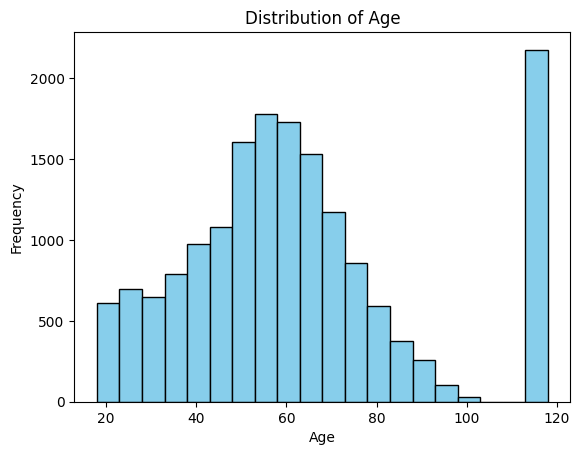

In [570]:
# Show distribution of age.
plt.hist(profile['age'], bins=20, color='skyblue', edgecolor = 'black')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Looks like the age just below 120 is an outlier.

#### Transcript Dataset Summary Stats

In [571]:
dataframe_summary(transcript)

Shape: (306534, 4) 

Head:
                              person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0   

Describe:
                 time
count  306534.000000
mean      366.382940
std       200.326314
min         0.000000
25%       186.000000
50%       408.000000
75%       528.000000
max       714.000000 

Data Types:
 person    object
event     object
value     object
time       in

In [572]:
# unique values of event
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

#### Data Cleaning

##### Portfolio Dataset

In [573]:
portfolio.columns

Index(['reward', 'channels', 'difficulty', 'duration', 'offer_type', 'id'], dtype='object')

In [574]:
# rename id column to offer_id
portfolio = portfolio.rename(columns= {"id" : "offer_id"})

In [575]:
# convert column channels into 4 different channels and add 1 or 0 in the values
# delete original channels column later
channels = portfolio["channels"].str.join(sep="*").str.get_dummies(sep="*")
portfolio = pd.concat([portfolio, channels], axis=1, sort=False)

In [576]:
# one hot encode offer type
# delete original offer_type column later
offer_type = pd.get_dummies(portfolio['offer_type'],dtype=int)
portfolio = pd.concat([portfolio, offer_type], axis=1, sort=False)

In [577]:
portfolio.head(2)

,reward,channels,difficulty,duration,offer_type,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0


##### Profile Dataset

In [578]:
profile.columns

Index(['gender', 'age', 'id', 'became_member_on', 'income'], dtype='object')

In [579]:
#change column name of id to customer_id
profile = profile.rename(columns={"id":"customer_id"})

In [580]:
#check duplicates
profile.duplicated().sum()

0

In [581]:
# convert the datatype of 'became_member_on' column and sort the date into proper format 
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [582]:
# get year from became_member_on column
profile['year_joined'] = profile['became_member_on'].dt.year

In [583]:
# check missing values
profile.isna().sum()

gender              2175
age                    0
customer_id            0
became_member_on       0
income              2175
year_joined            0
dtype: int64

In [584]:
# age of 118 doesnot look natural
age_118_count = profile[profile['age']== 118].age.count()
age_118 = profile.loc[profile.age == 118][['gender','age','income']]
print(age_118.head())
print('Count of customers with age == 118 is {}.'.format(age_118_count))

  gender  age  income
0   None  118     NaN
2   None  118     NaN
4   None  118     NaN
6   None  118     NaN
7   None  118     NaN
Count of customers with age == 118 is 2175.


In [585]:
# age = 118 corresponds to 2175 missing values of 'gender' and 'income' columns and
# remove these rows from the profile dataframe since it is a small fraction of the data
profile = profile.dropna()


In [586]:
profile.shape

(14825, 6)

In [587]:
profile['gender'].value_counts()

gender
M    8484
F    6129
O     212
Name: count, dtype: int64

In [588]:
# one hot encode gender column
# drop gender column later
gender_dummies = pd.get_dummies(profile["gender"], dtype=int)
profile = pd.concat([profile, gender_dummies], axis=1, sort=False)

In [589]:
profile.head(2)

,gender,age,customer_id,became_member_on,income,year_joined,F,M,O
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,1,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,1,0,0


##### Transcript Dataset

In [590]:
transcript.columns

Index(['person', 'event', 'value', 'time'], dtype='object')

In [591]:
# check nulls 
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [592]:
# change person to customer_id
transcript = transcript.rename(columns={"person":"customer_id"})

In [593]:
# one hot encode event
# delete event column later
event_dummies = pd.get_dummies(transcript["event"], dtype=int)
transcript = pd.concat([transcript, event_dummies], axis=1, sort=False)

In [594]:
transcript.head(2)

,customer_id,event,value,time,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0,0


In [595]:

# separating the 'value' column
# extract 'amount', 'offer_id, and 'reward' from the 'value' column into separate columns
# we will delete value column later
transcript['amount'] = transcript['value'].apply(lambda x: x.get('amount'))
transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer_id') if 'offer_id' in x else x.get('offer id'))
transcript['rewards'] = transcript['value'].apply(lambda x: x.get('reward'))


In [596]:
# transcript: drop transaction rows whose customer_id is not in profile:customer_id
transcript = transcript[transcript.customer_id.isin(profile.customer_id)]

In [597]:
transcript.head(2)

,customer_id,event,value,time,offer completed,offer received,offer viewed,transaction,amount,offer_id,rewards
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN


#### Combining the data

In [598]:
# combining profile and transcript 
profile_trans = pd.merge(transcript, profile, on='customer_id',how='left')

In [599]:
profile_trans.head(2)

,customer_id,event,value,time,offer completed,offer received,offer viewed,transaction,amount,offer_id,rewards,gender,age,became_member_on,income,year_joined,F,M,O
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0,2017,1,0,0
1,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,M,68,2018-04-26,70000.0,2018,0,1,0


In [600]:
# final dataframe consisting of profile, transcript and portfolio 
dataframe = pd.merge(profile_trans, portfolio, on='offer_id', how='left')

In [601]:
print("Shape of final dataframe is {}".format(dataframe.shape))
print("Columns in the final dataframe are {}".format(dataframe.columns))

Shape of final dataframe is (272762, 31)
Columns in the final dataframe are Index(['customer_id', 'event', 'value', 'time', 'offer completed',
       'offer received', 'offer viewed', 'transaction', 'amount', 'offer_id',
       'rewards', 'gender', 'age', 'became_member_on', 'income', 'year_joined',
       'F', 'M', 'O', 'reward', 'channels', 'difficulty', 'duration',
       'offer_type', 'email', 'mobile', 'social', 'web', 'bogo', 'discount',
       'informational'],
      dtype='object')


### Data Exploration & Data Visualization

##### Age Distribution

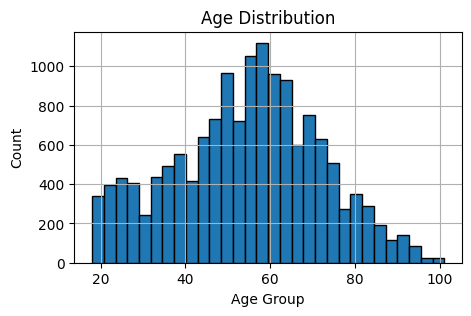

In [615]:
profile.age.hist(bins = 30,edgecolor="black",figsize=(5,3))
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Age Distribution');

We can see that most of the customers using the starbucks app lie in the age group of 45 to 65

##### Income Distribution

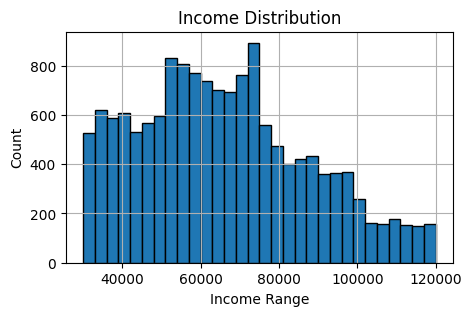

In [616]:
profile.income.hist(bins = 30,edgecolor="black",figsize=(5,3));
plt.xlabel('Income Range')
plt.ylabel('Count')
plt.title('Income Distribution');

Average income of user is middle income group ie. 55000-75000

##### Gender Distribution

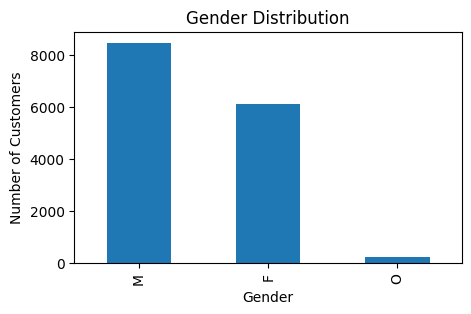

In [617]:
ax = profile.gender.value_counts()
ax.plot(kind='bar',figsize=(5,3))
plt.ylabel('Number of Customers')
plt.xlabel('Gender')
plt.title('Gender Distribution');

There are more males than females, using the starbucks app

##### Spending by Gender

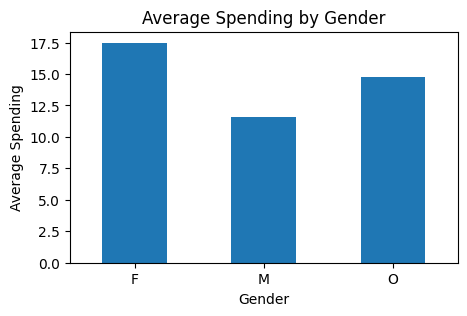

In [618]:
# Grouping the DataFrame by 'gender' and calculating the average spending for each gender
average_spending = dataframe.groupby('gender')['amount'].mean()

# Plotting a bar plot for average spending by gender
plt.figure(figsize=(5, 3))
average_spending.plot(kind='bar')
plt.title('Average Spending by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Spending')
plt.xticks(rotation=0);

Females are spending more than males

##### Gender Vs Membership Year

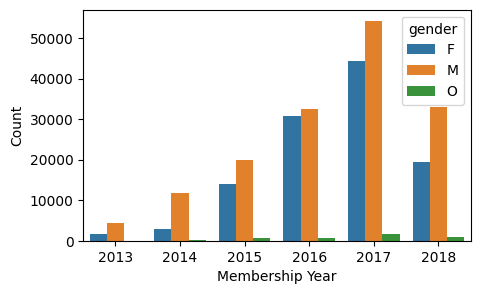

In [619]:
# groupby year joined and gender to plot a graph
membership_year = dataframe.groupby(['year_joined', 'gender']).size()
membership_year = membership_year.reset_index()
membership_year.columns = ['year_joined', 'gender', 'count']

plt.figure(figsize=(5, 3))
sns.barplot(x='year_joined', y='count', hue='gender', data=membership_year)
plt.xlabel('Membership Year')
plt.ylabel('Count');

We can see that most customers joined in 2017 and then in 2018. There are more male customers joining the program every year

##### Offer Type Distribution

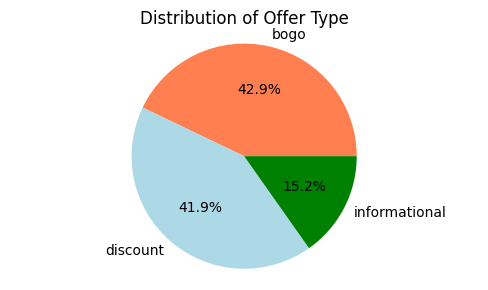

In [620]:
plt.figure(figsize=(5, 3))
plt.pie(dataframe['offer_type'].value_counts(), labels=dataframe['offer_type'].value_counts().index, autopct='%1.1f%%', colors=['coral', 'lightblue', 'green', 'lightskyblue'])
plt.title('Distribution of Offer Type')
plt.axis('equal')
plt.tight_layout();

We can see that majority of offers include bogo and discount and very few are informational

##### Offer Type Vs Offer Received, Offer Viewed and Offer Completed

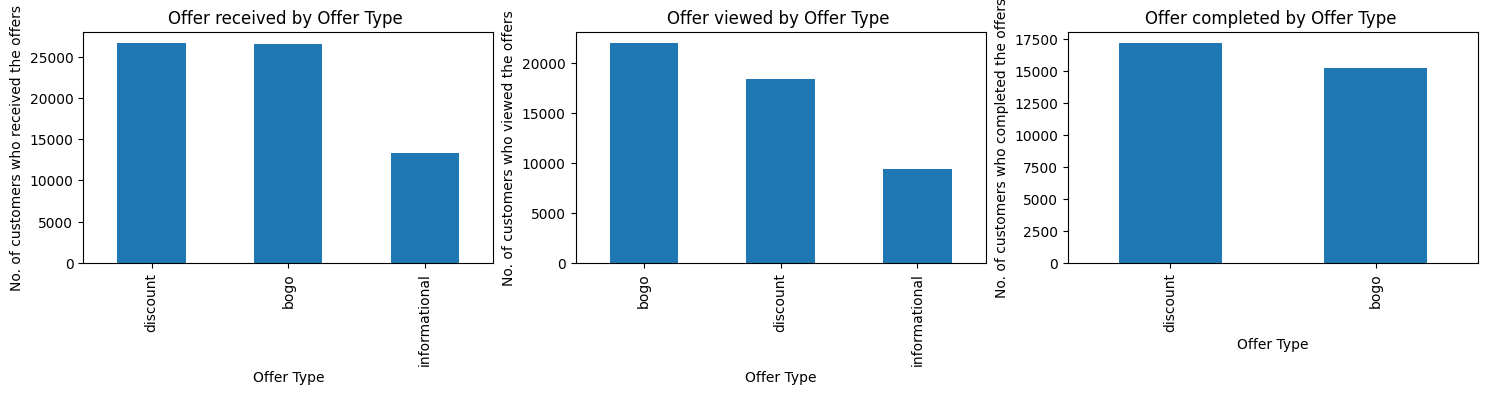

In [621]:
plt.subplot(131)
offer_received = dataframe.loc[dataframe['offer received'] == 1].offer_type.value_counts()
offer_received.plot(kind='bar', figsize=(18,3))
plt.ylabel('No. of customers who received the offers')
plt.xlabel('Offer Type')
plt.title('Offer received by Offer Type ');

plt.subplot(132)
offer_viewed = dataframe.loc[dataframe['offer viewed'] == 1].offer_type.value_counts()
offer_viewed.plot(kind='bar' , figsize=(18,3))
plt.ylabel('No. of customers who viewed the offers')
plt.xlabel('Offer Type')
plt.title('Offer viewed by Offer Type ');

plt.subplot(133)
offer_completed = dataframe.loc[dataframe['offer completed'] == 1].offer_type.value_counts()
offer_completed.plot(kind='bar' , figsize=(18,3))
plt.ylabel('No. of customers who completed the offers')
plt.xlabel('Offer Type')
plt.title('Offer completed by Offer Type ');

We can see from the above visualizations that, discount and bogo are the most received offers and bogo is the offer that has been viewed the most. But the discount offer has been completed the most.

##### Customer Response to Offers

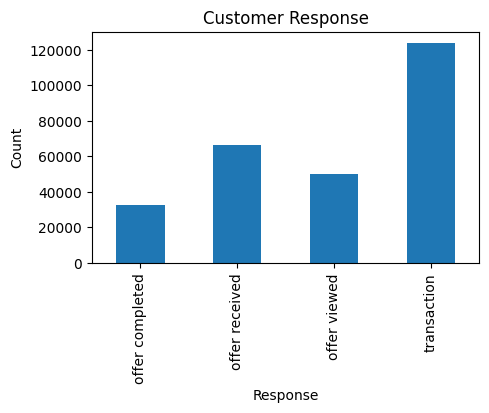

In [622]:
response = dataframe.groupby('event').size()
response.columns = ['response', 'count']

# plot a bar graph for customer response to offers
response.plot(kind = 'bar',figsize=(5,3))
plt.xlabel('Response')
plt.ylabel('Count')
plt.title('Customer Response');


In [623]:
offers_viewed = dataframe.loc[dataframe['event'] == "offer viewed"].shape[0]
offers_rec = dataframe.loc[dataframe['event'] == "offer received"].shape[0]
offers_completed = dataframe.loc[dataframe['event'] == "offer completed"].shape[0]


In [624]:
print("{} percent of the offers were viewed out of the total offers received".format(round(100*(offers_viewed/offers_rec),1)))

75.0 percent of the offers were viewed out of the total offers received


In [625]:
print("{} percent of the offers were completed out of the total offers received".format(round(100*(offers_completed/offers_rec),1)))

48.8 percent of the offers were completed out of the total offers received


##### Offers Completed Vs Gender, Age and Income

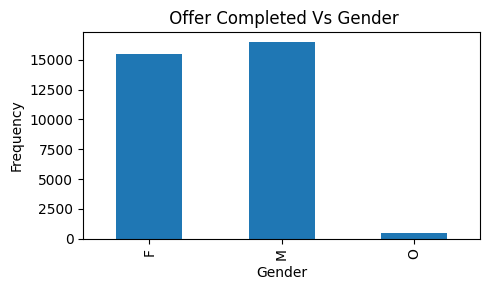

In [626]:
# Offers completed vs gender
dataframe[dataframe['offer completed']==1][['F','M','O']].sum().plot.bar(figsize=(5,3)) 
plt.title(" Offer Completed Vs Gender")
plt.xlabel("Gender")
plt.ylabel("Frequency")
plt.tight_layout();

Males are completing little more offers than females (since they are recieving more offers as well). Although, it is almost the same. 

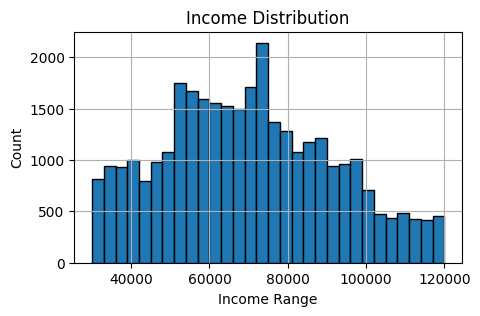

In [627]:
# Income Distribution of customers who completed the offer
dataframe_offer_comp = dataframe.loc[dataframe['offer completed'] == 1]
dataframe_offer_comp.income.hist(bins = 30,edgecolor="black",figsize=(5,3))
plt.xlabel('Income Range')
plt.ylabel('Count')
plt.title('Income Distribution');

Customers having income range 50k to 80k are completing the most offers

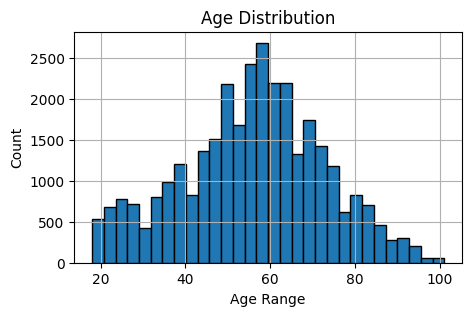

In [629]:
# Age Distribution of customers who completed the offer
dataframe_offer_comp.age.hist(bins = 30,edgecolor="black",figsize=(5,3))
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.title('Age Distribution');

The customers between the age of 50-70 are the most active in completing the offers

#### Data Preparation for ML Models

In [630]:
dataframe.columns

Index(['customer_id', 'event', 'value', 'time', 'offer completed',
       'offer received', 'offer viewed', 'transaction', 'amount', 'offer_id',
       'rewards', 'gender', 'age', 'became_member_on', 'income', 'year_joined',
       'F', 'M', 'O', 'reward', 'channels', 'difficulty', 'duration',
       'offer_type', 'email', 'mobile', 'social', 'web', 'bogo', 'discount',
       'informational'],
      dtype='object')

In [631]:
# deleting the value, event, channels and offer type columns as discussed earlier
dataframe = dataframe.drop(columns=['value','event','channels','offer_type','gender'])

In [632]:
# removing the rows where offer id is null, since we are building a model 
# to predict whether a customer will complete an offer
dataframe = dataframe.dropna(subset=['offer_id'])

In [635]:
# deleting the transaction, amount and rewards column as well
dataframe = dataframe.drop(columns=['transaction','amount','rewards'])

Also as seen in the project description above, there might be a case that someone using the app might make a purchase through the app without having received an offer or seen an offer.

In [636]:
dataframe[dataframe["offer completed"] == 1][["offer received", 'offer viewed', 'informational']].sum()

offer received    0.0
offer viewed      0.0
informational     0.0
dtype: float64

In [637]:
# Getting the X and Y (features and target), dropping customer_id, 
# offer_id, offer viewed, offer received, informational and became_memeber_on (we are keeping year_joined)
features = dataframe.drop(columns=['customer_id','offer_id','became_member_on','offer viewed','offer received','informational','offer completed'])
label = dataframe['offer completed']

##### Training the model

In [638]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, random_state=42)

In [639]:
print("Size of training dataset is {}".format(X_train.shape))
print("Size of test dataset is {}".format(X_test.shape))

Size of training dataset is (104163, 16)
Size of test dataset is (44642, 16)


#### Implementing ML Models 

In [641]:
# Import the models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix

objects = ('DT', 'AdaBoost', 'GB', 'RF')

In [642]:
# function to train classifier
def train_classifier(clf, X_train, y_train):    
    clf.fit(X_train, y_train)

# function to predict features 
def predict_labels(clf, features):
    return(clf.predict(features))


In [643]:
# Initialize the models
model_1 = DecisionTreeClassifier(random_state=42)
model_2 = AdaBoostClassifier(n_estimators=50) 
model_3 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model_4 = RandomForestClassifier(n_estimators=40,random_state=42)

In [644]:
# call function for each model & print the F1 score
clf = [model_1,model_2,model_3,model_4]
pred_val = [0,0,0,0]

for a in range(0,4):
    train_classifier(clf[a], X_train, y_train)
    y_pred = predict_labels(clf[a],X_test)
    pred_val[a] = f1_score(y_test, y_pred) 
    print("Model: {} F1 Score: {}".format(clf[a],pred_val[a]))

Model: DecisionTreeClassifier(random_state=42) F1 Score: 0.47450410219129713
Model: AdaBoostClassifier() F1 Score: 0.3745638396354055
Model: GradientBoostingClassifier(random_state=42) F1 Score: 0.5592155481181375
Model: RandomForestClassifier(n_estimators=40, random_state=42) F1 Score: 0.29117367921543813


In [646]:
# generating classification report for each model
class_report = ['','','','']
for a in range(0,4):
    train_classifier(clf[a], X_train, y_train)
    y_pred = predict_labels(clf[a],X_test)
    class_report[a] = classification_report(y_test, y_pred) 
    print("{} Model: {}".format(class_report[a],clf[a]))


              precision    recall  f1-score   support

           0       0.85      0.86      0.86     34909
           1       0.48      0.47      0.47      9733

    accuracy                           0.77     44642
   macro avg       0.67      0.66      0.66     44642
weighted avg       0.77      0.77      0.77     44642
 Model: DecisionTreeClassifier(random_state=42)
              precision    recall  f1-score   support

           0       0.82      0.95      0.88     34909
           1       0.61      0.27      0.37      9733

    accuracy                           0.80     44642
   macro avg       0.72      0.61      0.63     44642
weighted avg       0.78      0.80      0.77     44642
 Model: AdaBoostClassifier()
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     34909
           1       0.65      0.49      0.56      9733

    accuracy                           0.83     44642
   macro avg       0.76      0.71      0.73     44642

Since Gradient Boosting Classifier provides better result compared to other techniques lets perform Grid Search on Gradient Boosting to obtain the best parameters

In [544]:
# Create the Gradient Boosting Classifier
clf = GradientBoostingClassifier(random_state=42)

# Define hyperparameters for tuning
param_grid = {'n_estimators': [50, 100, 150], 'learning_rate': [0.05, 0.1, 0.2],'max_depth': [3, 4, 5]}

# Perform Grid Search to find the best parameters
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy') 
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_ 
print("Best Parameters:", best_params)

# Predict on the test set
y_pred = grid_search.predict(X_test)

# generate classification report
classification_rep = classification_report(y_test, y_pred) 
print("Classification Report:") 
print(classification_rep)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     34909
           1       0.64      0.58      0.61      9733

    accuracy                           0.84     44642
   macro avg       0.76      0.74      0.75     44642
weighted avg       0.83      0.84      0.83     44642



In [647]:
# Since Best Parameters are: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100} 
# training the model with these parameters and making predictions
model_3 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.2, max_depth=4, random_state=42)

In [648]:
clf = [model_1,model_2,model_3,model_4]
train_classifier(clf[2], X_train, y_train)
y_pred = predict_labels(clf[2],X_test)
pred_val[2] = f1_score(y_test, y_pred) 
print("Model: {} F1 Score: {}".format(clf[2],pred_val[2]))

Model: GradientBoostingClassifier(learning_rate=0.2, max_depth=4, random_state=42) F1 Score: 0.6070735389260299


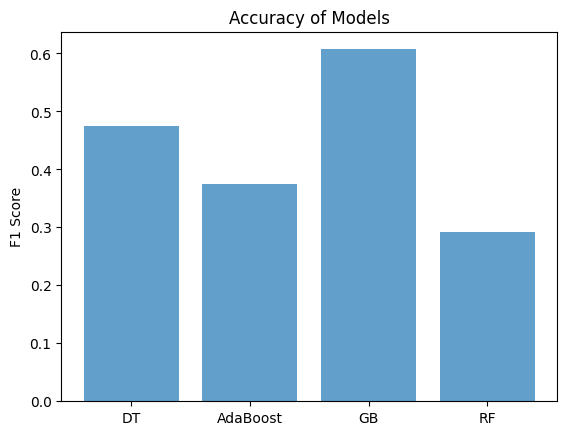

In [649]:
# ploating data for F1 Score
y_pos = np.arange(len(objects))
y_val = [ x for x in pred_val]
plt.bar(y_pos,y_val, align='center', alpha=0.7)
plt.xticks(y_pos, objects)
plt.ylabel('F1 Score')
plt.title('Accuracy of Models')
plt.show()

**We can see that Gradient Boosting Classifier is perfoming the best in this case.**

Accuracy measures how well a model correctly predicts whether an offer is successful. 
However, if the percentage of successful or unsuccessful offers is very low, accuracy is not a good measure of model performance. 

Hence in this situation, evaluating a models' precision and recall provides better insight into its performance. F1-score metric is chosen here because it is a weighted average of the precision and recall metrics.

## Conclusion

### Reflection

In this project about the Starbucks offers data, we worked with 3 json data files including portfolio data, profile data and transcript data. 
We began by inspecting the three datasets and then cleaning them, post that we merged the datasets and then created some visualisations to further convey the information associated with our data exploration journey.

These are major goals we started with -

- Which demographic groups respond best to which offer type.
- Create Machine Learning model to predict whether a customer will complete an offer. 

The following are the outcome of our analysis - 

- Majority of the customers using the starbucks app lie in the age group of 45 to 65 and the income of most of the customers lies between 55k to 75k.
- More males are using the app, but the average spending of females is more.
- Most customers joined in 2017 and then in 2018. There are more male customers joining the program every year.
- 75 % of the offers were viewed out of the total offers received, and 48.8 % of the offers were completed out of the total offers received.
- Male and Female almost equally complete the offer. So offers should be sent equally among them.
- Customers having income range 50k to 80k are completing the most offers and more offers (BOGO and Discount) should be sent to them. 
- The customers between the age of 50-70 are the most active in completing the offers

During the course of this project, the most challenging task was to prepare the data for the model implementation and identify the features. It was interesting to train the (Decision Tree, Ada Boost, Gradient Boosting and Random Forest) models and make predictions. Performing grid search to find out the best parameters for the Gradient Boosting Classifier was also intriguing.

### Improvement

- As suggested, we can build a machine learning model that predicts how much someone will spend based on demographics and offer type.
- Additional machine learning models can be tested along with feature scaling
- A web app can be made showcasing various visualizations and the result of the analysis and predictions by deploying the ML model to the web app
- Build Machine Learning Pipeline to seamlessly classify new data.